# Машинное обучение для временных рядов

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5

Возьмем датасет, в котором будет присутвовать переменная, изменяющася во времени. Давайте сегодня попробуем поработать с набором данных по среднесуточной дневной температуре в городе Дели, собранном за несколько лет. Подробнее почитать про датасет можно на [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

Датасет сразу разбит на две части - train и test, но будем использовать для обучения и валидации моделей только train, оставив test как отложенную выборку для проверки качества.

# ETNA (от Тинькофф)

Первая общедоступная версия библиотеки появилась в сентябре 2021 г.

In [ ]:
!pip install etna -q

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')

df = df[['date','meantemp']]

In [ ]:
df.head()

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


Приведем данные к формату, с которым работает ETNA:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - `main` в случае, если целевая переменная - это один ряд

In [ ]:
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["meantemp"]
df.drop(columns=["date", "meantemp"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2013-01-01,10.000000,main
1,2013-01-02,7.400000,main
2,2013-01-03,7.166667,main
3,2013-01-04,8.666667,main
4,2013-01-05,6.000000,main


В ETNA есть специальный класс для работы с временными рядами - TSDataset, приведем наши данные к этому формату.

In [ ]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Укажем временной шаг (дни).

In [ ]:
ts = TSDataset(df, freq="D")

ts.head()

segment,main
feature,target
timestamp,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2013-01-01    2016-12-31    1461            0


In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2013-01-01,2016-12-31,1461,0,1,0,0,0,D


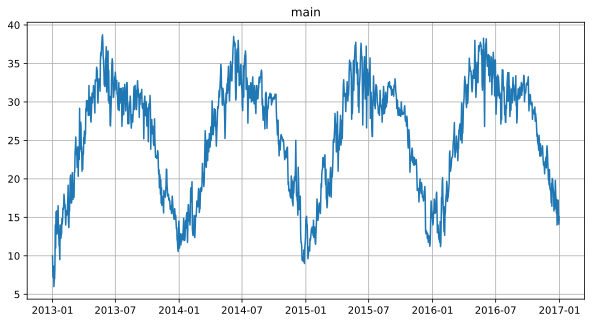

In [ ]:
ts.plot()

Разбиваем данные на тренировочную и тестовую части

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2013-01-01",
    train_end="2015-12-31",
    test_start="2016-01-01",
    test_end="2016-12-31",
)

В библиотеке ETNA реализовано множество самых разных моделей - от классической SARIMAX до нейронных сетей.

Обучим самую простую модель из ETNA - NaiveModel.

Наивная модель предсказывает текущее значение, равное значению ряда несколько периодов назад (lag):

$$y_t = y_{t-lag}$$

In [ ]:
HORIZON = 366 # горизонт прогнозирования

from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

# Fit the model
model1 = NaiveModel(lag=5)

model1.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)

forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

In [ ]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 50.067909843390055}

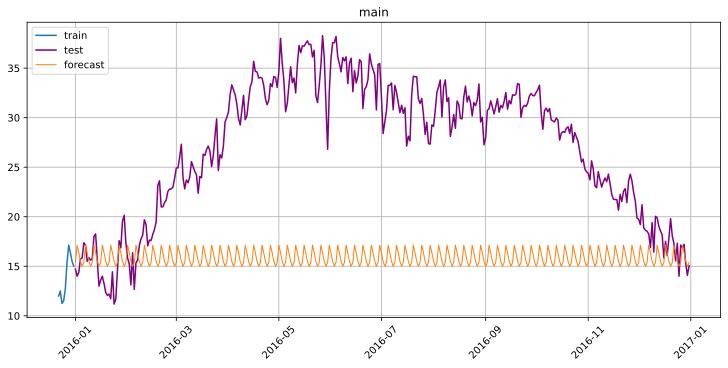

In [ ]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### Prophet (от Facebook)

Библиотека Prophet использует аддитивную модель для прогнозирования временных рядов. Аддитивная модель предполагает, что значение временного ряда можно разложить на несколько компонент, таких как тренд, сезонность, праздничные эффекты и остатки.

Модель Prophet выражается следующим уравнением:

$$y_t = g_t + s_t + h_t + e_t,$$

где:

* $g_t$ представляет тренд, моделирующий нелинейное изменение значения временного ряда во времени

* $s_t$ представляет сезонность, учитывающую повторяющиеся паттерны или циклы во временном ряду

* $h_t$ представляет праздничные эффекты, учитывающие влияние праздников и событий на временной ряд

* $e_t$ представляет остатки, которые предполагаются нормально распределенными шумами вокруг модели

Тренд моделируется с использованием гибкой линейной модели, которая может аппроксимировать нелинейные изменения во временном ряду. Сезонность моделируется с помощью фурье-рядов, позволяющих учесть сезонные колебания с различными периодами. Праздничные эффекты моделируются путем добавления индикаторов праздников в модель.

Prophet также автоматически настраивает гиперпараметры модели, такие как гибкость тренда и сезонности, а также влияние праздников. Он также предоставляет возможность пользователю настраивать некоторые параметры, такие как сезонность, шум и другие.

In [ ]:
from etna.models import ProphetModel

model2 = ProphetModel()

model2.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpddixqks0/uirivdt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpddixqks0/rdo_8hw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41452', 'data', 'file=/tmp/tmpddixqks0/uirivdt7.json', 'init=/tmp/tmpddixqks0/rdo_8hw9.json', 'output', 'file=/tmp/tmpddixqks0/prophet_modelg83f49o3/prophet_model-20230804093011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.532028749602292}

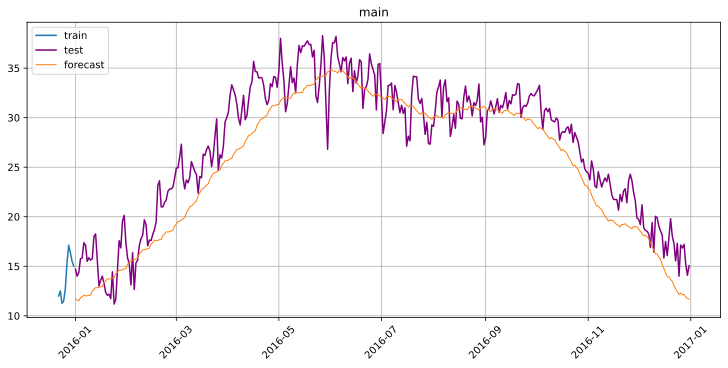

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

# Pipeline

Для обучения и валидации модели будем использовать сущность `Pipeline`. В целом, использование `Pipeline` позволит ускорить и упростить обучение и тестирование модели. Например, разбиение на тренировочные и тестовые выборки при запуске кросс валидации в таком случае будет производиться автоматически.

`Pipeline` имеет несколько параметров:

* `model` - модель, которая будет обучаться и тестироваться;
* `horizon` - горизонт прогнозирования;
* `transforms` - список преобразований, которые нужно применить к данным.

Ещё одним достоинством использования пайплайна является автоматическое прямое и обратное преобразование данных, следовательно, о согласованности данных можно не беспокоиться. Кросс валидацию на исторических данных можно запустить с помощью метода `backtest`.

In [ ]:
from etna.pipeline import Pipeline
from etna.metrics import MAE, SMAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

pipe = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=LinearPerSegmentModel(),
    horizon=3
)

## Backtest

Backtest - это кросс-валидация на временных рядах.

In [ ]:
metrics, forecast, _ = pipe.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

,segment,MAE,SMAPE,fold_number
0,main,0.956865,5.492141,0
0,main,1.679161,9.454322,1
0,main,1.986150,12.403313,2
0,main,0.500228,2.888707,3
0,main,0.352171,2.309867,4


In [ ]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

1.094914868018162

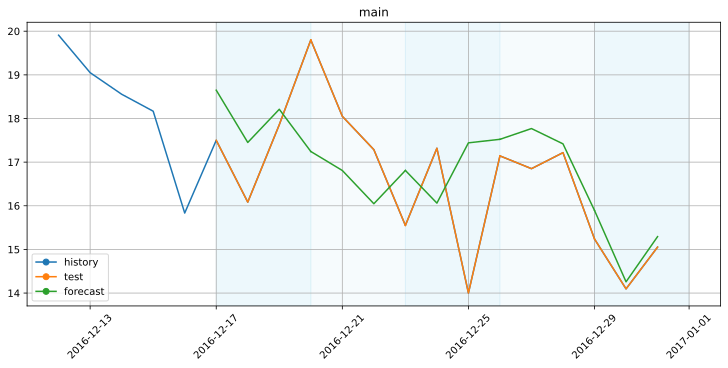

In [ ]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df=forecast, ts=ts, history_len=5)

In [ ]:
pipe2 = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=CatBoostMultiSegmentModel(n_estimators=1000, learning_rate=0.01),
    horizon=3
)

In [ ]:
metrics, forecast, _ = pipe2.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   14.9s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

,segment,MAE,SMAPE,fold_number
0,main,0.606679,3.509500,0
0,main,1.688889,9.534459,1
0,main,2.000959,12.491365,2
0,main,0.399407,2.309858,3
0,main,0.238378,1.558969,4


In [ ]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

0.9868626308337773

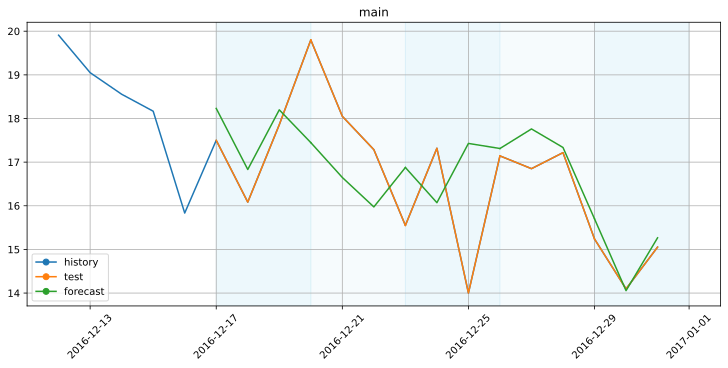

In [ ]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=5)

Примеры ноутбуков с использованием ETNA:

* [tutorial из документации](https://github.com/tinkoff-ai/etna/blob/master/examples/get_started.ipynb)

* [семинар с курса "Прикладные задачи машинного обучения" в ВШЭ](https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem07_ts2/sem07_ts2.ipynb)